In [ ]:
# навчити модель класифікувати мурашок і бджіл. Навчальний набір даних складається з близько 120 зображень кожного класу. Також для кожного класу є 75 тестових зображень.
# це дуже малий набір даних для якісного узагальнення, якщо навчання моделі відбувається з нуля. Оскільки ми використовуємо трансферне навчання, ми повинні мати достатньо хороші узагальнення навіть на малому обсязі даних.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# Enables the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
# Effective when input sizes for the network do not vary.
cudnn.benchmark = True

plt.ion() # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),   # Навчальні й тестові зображення матимуть розмір 224 х 224
        transforms.ToTensor(),          # Цей розмір є конвенцією ML-спільноти, яка була прийнята для стандартизації попередньої обробки й забезпечення узгодженості в різних моделях та експериментах.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    # Normalize приймає два аргументи:  mean (sequence) — послідовність середніх для кожного каналу,
                                                                                #                                 std (sequence) — послідовність стандартних відхилень для кожного каналу.
        # Для n каналів це перетворення нормалізує кожен канал вхідного тензора: output[channel] = (input[channel] - mean[channel]) / std[channel].
        # Ці конкретні значення mean і std обрані так, щоб відповідати середньому значенню та стандартному відхиленню набору даних ImageNet.
        # Претренованою моделлю (pre-trained model, backbone model) для донавчання (fine-tuning) у цьому конкретному завданні ми використаємо модель, навчену на цьому наборі даних.
        # Відповідно ми підготовлюємо наші вхідні дані так, щоб вони були максимально схожими на зображення з ImageNet.
    ]),
}

In [ ]:
# data_path = 'https://raw.githubusercontent.com/alexvekh/DL-course/main/data/Module_3_Lecture_2_hymenoptera_data/'
# Створимо клас Dataset
data_dir = '/content/drive/MyDrive/ds/Module_3_Topic_6_hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Створимо клас DataLoader.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# Збережемо інформацію про розмір датасету та назви класів.
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 244, 'val': 153}
['ants', 'bees']


In [ ]:
# Створимо функцію для відображення прикладів.
def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # Imagenet mean
    std = np.array([0.229, 0.224, 0.225]) # Imagenet std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

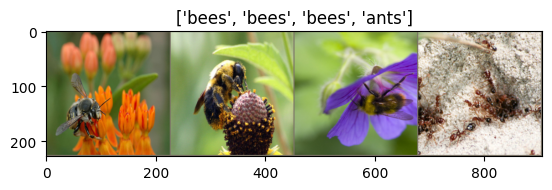

In [ ]:
# Get a batch of training data  /  Візуалізуємо один батч даних.
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Тренування й валідація моделі

In [ ]:
# Ми будемо відстежувати продуктивність (performance) моделі через метрику точності та зберігати найкращу модель.

# Під час збереження моделі достатньо лише зберегти вивчені параметри моделі.
# Збереження state_dict моделі за допомогою функції torch.save() дає найбільшу гнучкість для відновлення моделі пізніше,
# тому це рекомендований метод для збереження моделей.

# Напишемо загальну функцію train_model, яка буде виконувати навчання й валідацію моделі протягом num_epochs.
# Кінцевим результатом роботи функції буде модель, що показала найвищу точність на валідації.

def train_model(model, criterion, optimizer, num_epochs=25):# scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
# Також створимо функцію для візуалізації результатів.
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

У трансферному навчанні використовуються два основні підходи:
- тренування всіх ваг моделі
- заморожування ваг, що витягують ознаки, з тренуванням лише шару класифікації

## Тренування всієї моделі
У цьому підході всі шари моделі, зокрема початкові шари, які витягують ознаки, і шар класифікації, тренуються на новому наборі даних.

Переваги:

- Більша гнучкість. Модель може краще адаптуватися до специфічних ознак нового набору даних, оскільки всі ваги можуть змінюватися.
- Краща продуктивність. Для складних завдань або задач, де новий набір даних сильно відрізняється від початкового, тренування всіх ваг може призвести до кращої продуктивності.

Недоліки:

- Потреба в більшій кількості даних. Тренування всіх ваг потребує більше даних, щоб уникнути перенавчання (overfitting).
- Більші вимоги до ресурсів. Тренування всіх шарів вимагає більше обчислювальних ресурсів і часу.
- Явище катастрофічного забування (Catastrophic Forgetting)


Катастрофічне забування виникає при навчанні нейронної мережі, особливо в контексті навчання з новими даними. Це явище полягає в тому, що при навчанні на нових зразках або задачах нейронна мережа забуває попередні знання або навички, які вона вже вивчила.



Основна причина катастрофічного забування полягає в тому, що під час навчання ваги нейронної мережі переструктуруються, щоб адаптуватися до нових даних або завдань. Це може призвести до того, що ваги, які були оптимізовані для розв'язання попередніх завдань, переструктуруються так, що неефективно розв'язуватимуть нові завдання, або навіть просто забудуться.


Під час навчання нових даних або завдань ваги мережі можуть вдосконалюватися для нових зразків, проте це може призвести до втрати здатності до розв'язання попередніх завдань.


Для боротьби з катастрофічним забуванням використовуються різні підходи, такі як методи навчання з додаванням невеликої кількості даних попередніх задач, регуляризація моделі й використання методів збереження ваг моделі.

## Заморожування ваг

У цьому підході початкові шари моделі, які дістають загальні ознаки, заморожуються, і тренуються лише останні шари, відповідальні за класифікацію.

Переваги:

- Менше даних для навчання. Заморожування більшості ваг дозволяє ефективно тренувати модель навіть на невеликих наборах даних.
- Швидше навчання. Менше ваг для тренування означає швидший процес навчання.
- Зменшений ризик перенавчання. Менша кількість параметрів, які змінюються, знижує ризик перенавчання.


Недоліки:

- Обмежена адаптація. Модель може бути менш гнучкою у випадку, якщо новий набір даних сильно відрізняється від початкового.
- Можливі проблеми з узагальненням. Якщо ознаки, витягнуті початковими шарами, не повністю відповідають новому набору даних, продуктивність може бути меншою.
- Обмежена продуктивність. Для дуже специфічних завдань цей підхід може не забезпечити найкращу продуктивність, оскільки початкові шари залишаються незмінними.


## Вибір підходу

Вибір підходу залежить від специфіки задачі й доступних ресурсів:

- Для великих наборів даних і задач, що сильно відрізняються від вихідного завдання, варто розглядати тренування всієї моделі.
- Для невеликих наборів даних і завдань, що мають схожість із вихідним завданням, доцільно використовувати заморожування початкових шарів і тренування лише шару класифікації.


Обидва підходи мають свої місця в арсеналі методів трансферного навчання й можуть бути комбіновані для досягнення оптимальних результатів.

# Train all

In [ ]:
# Завантажимо претреновані ваги моделі ResNet.
# Оскільки в нас доволі невеликий обсяг даних, ми можемо використати невелику версію моделі ResNet-18, яка містить 18 шарів.

# У параметрі weights зазначимо посилання на набір даних ImageNet.
model_ft = models.resnet18(weights='IMAGENET1K_V1')
# Нам потрібно встановити останній fully-connected шар лінійним шаром, який на виході матиме кількість нейронів, рівну кількості класів моделі.
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)
# Переведемо модель на доступний обчислювальний пристрій — CPU або GPU.
model_ft = model_ft.to(device)
# Для створення прикладу, який можна буде використати в інших задачах, будемо працювати з цією задачею як із задачею багатокласової класифікації.
# Відповідно функцією втрат буде CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# У якості алгоритму оптимізації вистачить SGD.
# Observe that all parameters are being optimized  / Зверніть увагу, що всі параметри моделі оптимізуються.
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-05)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


In [ ]:
# Виконаємо навчання моделі протягом 5 епох. Результати тренування надрукуємо в консоль.
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=5)

NameError: name 'train_model' is not defined

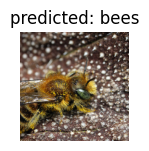

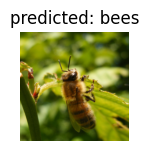

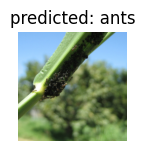

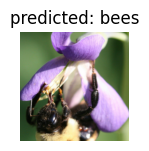

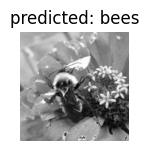

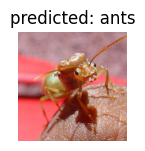

In [ ]:
# Отже, тренування моделі тривало майже 4 хвилини, а досягнута точність становила 0.94.
visualize_model(model_ft)

# Freeze weights

In [ ]:
# Тепер виконаємо тренування тільки класифікаційного шару.
# Усі інші ваги моделі будуть «заморожені» (frozen) — тобто для ваг цих шарів ми не будемо розраховувати градієнти й виконувати процедуру оновлення ваг.

# Для початку знову завантажимо модель ResNet18, претреновану на датасеті ImageNet.

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Тепер для всіх параметрів моделі встановимо параметр requires_grad = False
for param in model_conv.parameters():
    param.requires_grad = False
# Тепер додамо класифікаційний шар. Параметри новостворених шарів за замовчуванням мають requires_grad = True.
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# Усі інші аспекти тренування залишаємо незмінними.

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# Зверніть увагу, що в оптимізатор ми передаємо тільки параметри повнозв’язного шару model_conv.fc.parameters().
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=1e-03)# lr=0.001, momentum=0.9)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.6224 Acc: 0.6393
val Loss: 0.4501 Acc: 0.8105

Epoch 2/5
----------
train Loss: 0.4294 Acc: 0.7992
val Loss: 0.3027 Acc: 0.8954

Epoch 3/5
----------
train Loss: 0.4846 Acc: 0.7541
val Loss: 0.2747 Acc: 0.9150

Epoch 4/5
----------
train Loss: 0.5071 Acc: 0.7459
val Loss: 0.2130 Acc: 0.9346

Epoch 5/5
----------
train Loss: 0.3523 Acc: 0.8279
val Loss: 0.1894 Acc: 0.9346

Training complete in 0m 21s
Best val Acc: 0.934641


In [ ]:
# Cпостерігаємо, що навчання зайняло удвічі менше часу, а точність на найкращій епосі перевищила точність моделі, в якій оновлювалися всі ваги.
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

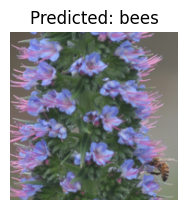

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/ds/Module_3_Topic_6_hymenoptera_data/val/bees/1328423762_f7a88a8451.jpg'
)

plt.ioff()
plt.show()